<img src="scikit_learn_logo.png">

## Árboles de decisión II

Como comentábamos al final del capítulo anterior, uno de los conceptos más importantes en estos algorítmos ( y en general en los modelos de predicción ) es el **sobreajuste**.

Un modelo se sobreajusta cuando se acopla demasiado a las muestras con las cuales ha sido entrenado. De esta forma, el modelo **pierde su capacidad de generalización**. Es decir, este modelo será capaz de ajustar bien las muestras con las que ha sido entrenado, pero cuando tenga que clasificar muestras nuevas,que desconoce, no tendrá buen rendimiento.

Con un modelo basado en árbol de decisión es bastante probable que ocurra esto, y por lo tanto se debe estudiar esta posibilidad y en tal caso tomar acción: **regularizarlo** o bien conseguir más muestras de entrenamiento.

¿Qué formas tenemos para regularizar un árbol?

Varias. Podemos por ejemplo limitar el número de nodos que tenga el árbol, su profundidad, de tal forma que no exitan tantas ramas con grupos tan específicos. Otra forma es establacer un umbral de muestras minímas por
nodo a partir del cual se podrá hacer una nueva división. Lo mismo con la entropía/gini, etc.

Estas regularizaciones que se acaban de comentar se establecen con los parámetro comentados en el capítulo anterior. Lo suyo es ir probar varias combinaciones y quedarnos con la que mejor resultado nos de. Scikitlearn nos ofrece una función para crear una **malla** y probar combinaciones de parámetros: **GridSearchCV**.

En este capítulo vamos a explicar los tipos de errores asociados a modelos, como elegir los mejores parámetros para un árbol y visualizar las curvas de aprendizaje.

In [121]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix                             
from sklearn.model_selection import train_test_split, learning_curve,\
                                    GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# la bbdd que usaremos tiene que ver con vinos
vinos_path = os.path.join(os.getcwd(), '..', 'datasets', 'Vino', 'wine.csv')
vinos_df = pd.read_csv(vinos_path)

In [122]:
# echamos un vistazo a lo datos
vinos_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [123]:
vinos_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


La variable objetivo es **quality**. Vamos a categorizarla, para tener un problema de clasificación. Generaremos tre grupos: 

- malo: intervalo **3 - 4**
- normal: intervalo **5 - 6**
- bueno: intervalo **7 - 8**

In [124]:
# funcion para categorizar que usaremos con apply
def define_calidad(row):
    """
    Categoriza la variable quality.
    
    @param row: una fila del df
    @return: devuelve la agrupación correspondiente
    """
    quality = row['quality']
    if quality <= 5:
        return 'malo'
    elif quality >=7:
        return 'bueno'
    else:
        return 'normal'

In [125]:
# convertimos la variable con los valores definidos
vinos_df['quality'] = vinos_df.apply(define_calidad, axis = 1)

In [126]:
# veamos cuantos valores tenemos de cada tipo
vinos_df['quality'].value_counts()

malo      744
normal    638
bueno     217
Name: quality, dtype: int64

Separemos nuestro set de testeo y entrenamiento, usaremos todas la variables de la base de datos para entrenar el modelo:

In [127]:
X = vinos_df.drop(columns = ['quality'])
y = vinos_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   random_state = 42)

Ahora vamos a graficar las curvas de la precisión del modelo en función del tamaño de la muestra. Usaremos **learning curve**.

Esta función calcula la métrica que deseamos sobre el set de entrenamiento y validación para diferentes tamaños de muestras.

El set de validación es un subconjunto del set de entranamiento que se utiliza como para hacer pruebas durante la etapa de entrenamiento sin usar el set de testeo original, que solo debemos utilizar al final del ejercicio.

En función de la forma de las curvas podremos ver si nuestro modelo **sobreajusta** o por el contrario **sobresimplifica**.

In [128]:
# Inicializamos el árbol de decisión con parámetros por defecto
arbol_default = DecisionTreeClassifier() 


In [129]:
# aplicamos la funcion learning_curve
# primer parametro un tipo de algoritmo: nuestro arbol
# segundo y tercer parametros: el set de entranamiento
# cv: 10 divisiones para la validación cruzada
# scoring: tipo de metrica que queremos sacar
# train_sizes: vector con los tamaños de muestras incrementales
tamaños, training_resultados, testing_resultados = learning_curve(arbol_default,\
                                                        X_train,\
                                                        y_train,\
                                                        cv=10,\
                                                        scoring='accuracy',\
                                                        train_sizes=np.linspace(0.01, 1.0, 50)) 


¿ Qué es la **validación cruzada** ? 

Los datos de muestra (en este caso los de entranamiento) se dividen en K subconjuntos, (cv = 10). **Uno de los subconjuntos** se utiliza como datos de prueba y el **resto (K-1)** como datos de entrenamiento.
Este proceso de validación cruzada se repite K iteraciones (de nuevo, 10 para nuestro ejemplo)

In [130]:
# training_scores y testing_scores tienen 10 valores para cada iteracion
# de la curva de aprendizaje
training_scores.shape

(50, 10)

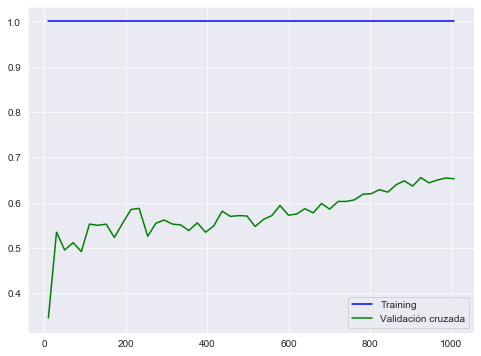

In [133]:
# sacamos la media para cada iteracion y graficamos
media_training = np.mean(training_resultados, axis=1) 
media_testing = np.mean(testing_resultados, axis=1) 
  
plt.figure(figsize = (8,6))    
sns.lineplot(sizes, media_training, color="b",  label="Training") 
sns.lineplot(sizes, media_testing, color="g", label="Validación cruzada");

Lo que vemos en la gráfica es que para el set de entrenamiento, el modelo clasifica perfectamente, mientras que para la validación cruzada (los datos "nuevos"), el rendimiento va mejorando a medida que aumenta el tamaño de la muestra lentamente, y bastante por debajo de la curva anterior. Esto en resumen nos dice que el modelo esta sobreajustado. 

Vamos a regularizar el árbol de una manera exagerada para hacer que el modelo este sobresimplificado y veamos que forma tendrían las curvas en estos casos:

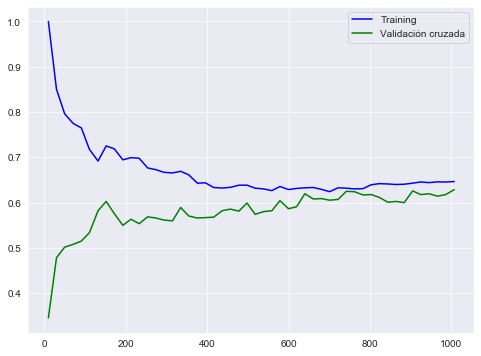

In [134]:
# Reducimos a una profundidad máxima de 3, lo que da lugar a un árbol
# realmente pequeño 
arbol_podado = DecisionTreeClassifier(max_depth = 3) 

tamaños, training_resultados, testing_resultados = learning_curve(arbol_podado,\
                                                        X_train,\
                                                        y_train,\
                                                        cv=10,\
                                                        scoring='accuracy',\
                                                        train_sizes=np.linspace(0.01, 1.0, 50)) 

media_training = np.mean(training_resultados, axis=1) 
media_testing = np.mean(testing_resultados, axis=1) 
  
plt.figure(figsize = (8,6))    
sns.lineplot(sizes, media_training, color="b",  label="Training") 
sns.lineplot(sizes, media_testing, color="g", label="Validación cruzada");

Esta vez la curva para el set de entrenamiento decrece y termina dando como último valor aproximadamente un 65% de precisión. 

¿Por qué tiene esta forma la curva?

Al comienzo del todo, cuando se tienen muy pocas muestras, el modelo con una profundidad máxima de 3 es capaz de ajustarse perfectamente a los datos, a medida que se van cogiendo más datos y, existe **más diversidad** en consecuencia, el modelo **no es capaz de representar** bien los datos.

¿Qué tipos de errores tenemos?
- error **tipo bias**: el modelo toma una serie de suposiciones que dan lugar a una sobresimplificación. Es decir, el modelo es demasiado sencillo.
- error de **varianza**: el modelo se ajusta demasiado a los datos con los que entrena. Cada pequeña variación de los mismos, hace que el modelo cambie. Esto hace que termine generalizando mal
    
Lo ideal es encontrar un equilibrio entre ambos.

Vamos ahora a utilizar una malla para tratar de encontrar el modelo que mejor resultado da para este problema en concreto. Usaremos la funcion **GridSearchCV()**:

In [137]:
arbol = DecisionTreeClassifier()

In [140]:
# Definimos el diccionario para las combinaciones de parametros
param_grid = {'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random'],
             'max_depth': [15,20,25],
             'min_samples_split': [2,5,10],
             'ccp_alpha':[0, 0.05, 0.1, 0.5, 1]}

malla = GridSearchCV(estimator = arbol,     # estimador
                     param_grid = param_grid,  # parametros que queremos probar
                     cv = 5,            # 5 subconjuntos para cada combinacion
                     refit = False,     # Entrenar el arbol con la mejor combi.
                     scoring = 'accuracy' # metrica para comparar
                    ) 

malla.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ccp_alpha': [0, 0.05, 0.1, 0.5, 1],
                

In [141]:
malla.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ccp_alpha': [0, 0.05, 0.1, 0.5, 1],
                

Una vez entrenada la malla, podemos acceder a la mejor combinación estimada por la misma con el atributo **best_params_**:

In [142]:
print(malla.best_params_)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'splitter': 'best'}


Entrenamos entonces el árbol con estos parametros, vemo cual es su rendimiento final y posteriormente visualizamos de nuevo las curvas de aprendizaje:

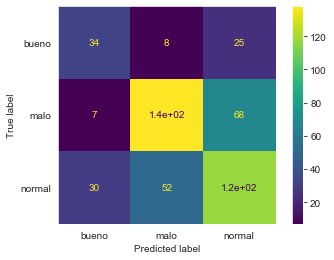

In [144]:
arbol = DecisionTreeClassifier(**malla.best_params_)
arbol.fit(X_train, y_train)

plot_confusion_matrix(arbol, X_test, y_test)
plt.grid(False)

Los errores están claramente descompensados. No son independientes del tipo de vino.

Para los vinos de tipo **bueno** el rendimiento es realmente pobre, clasificándose mal casi la mitad de las veces. Incluso a veces se toman vinos tipo **bueno** como si fuesen tipo **malo**. Esto nos da una idea de posibles acciones que pueden tomarse para mejorar el rendimiento.

In [145]:
# Veamos directamente su precisión general
predicciones = arbol.predict(X_test)
accuracy_score(y_test, predicciones)

0.6041666666666666

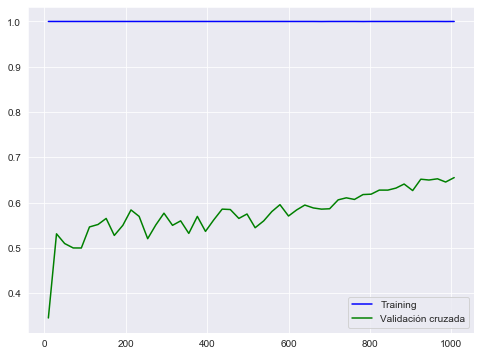

In [143]:
# Sacamos las curvas de aprendizaje
arbol = DecisionTreeClassifier(**malla.best_params_)

tamaños, training_resultados, testing_resultados = learning_curve(arbol,\
                                                        X_train,\
                                                        y_train,\
                                                        cv=10,\
                                                        scoring='accuracy',\
                                                        train_sizes=np.linspace(0.01, 1.0, 50)) 

media_training = np.mean(training_resultados, axis=1) 
media_testing = np.mean(testing_resultados, axis=1) 
  
plt.figure(figsize = (8,6))    
sns.lineplot(sizes, media_training, color="b",  label="Training") 
sns.lineplot(sizes, media_testing, color="g", label="Validación cruzada");

La mejor combinación posible de parámetros para un árbol de decisión en este problema da lugar a un modelo con una precisión bastante baja y además el modelo sobreajusta.

¿Qué hacemos entonces?

Este es un claro ejemplo de situación en la que un **aumento en el número de muestras de entrenamiento mejoraría el rendimiento del modelo**, ya que la curva de validación cruzada tiene una tendencia positiva. Más muestras reducirían el error por varianza.

A lo mejor en una situación real, esta solución no es viable por coste por ejemplo. En este caso, podríamos tratar de usar otras variables explicativas para el modelo ( nuevas, generadas, o incluso quitar alguna que pueda estar afectando negativamente al modelo).

Y otra opción sería probar otros modelos de clasificación, que posiblemente puedan tener un mejor desempeño en este problema.

